In [ ]:
# Dataset - https://www.kaggle.com/datasets/salader/dogs-vs-cats

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:28<00:00, 44.2MB/s]
100% 1.06G/1.06G [00:28<00:00, 40.8MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [6]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [7]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [8]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 77s 107ms/step - loss: 1.2161 - accuracy: 0.5766 - val_loss: 0.8022 - val_accuracy: 0.5756
Epoch 2/10
625/625 [==============================] - 68s 108ms/step - loss: 0.6022 - accuracy: 0.6844 - val_loss: 0.6740 - val_accuracy: 0.6144
Epoch 3/10
625/625 [==============================] - 66s 104ms/step - loss: 0.5145 - accuracy: 0.7501 - val_loss: 0.4620 - val_accuracy: 0.7874
Epoch 4/10
625/625 [==============================] - 65s 104ms/step - loss: 0.4431 - accuracy: 0.7954 - val_loss: 0.5045 - val_accuracy: 0.7522
Epoch 5/10
625/625 [==============================] - 65s 103ms/step - loss: 0.3888 - accuracy: 0.8275 - val_loss: 0.4191 - val_accuracy: 0.8086
Epoch 6/10
625/625 [==============================] - 78s 125ms/step - loss: 0.3296 - accuracy: 0.8566 - val_loss: 0.7050 - val_accuracy: 0.6658
Epoch 7/10
625/625 [==============================] - 68s 108ms/step - loss: 0.2611 - accuracy: 0.8857 - val_loss: 0.5438 - val_ac

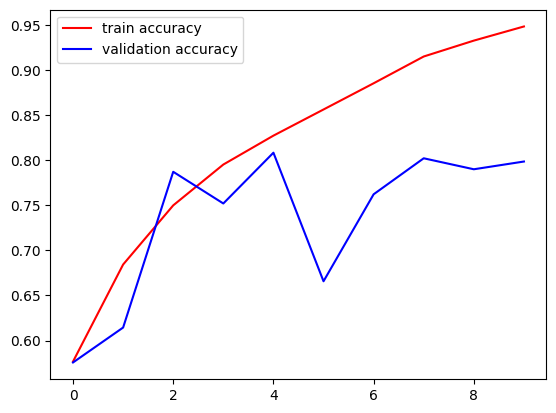

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='validation accuracy')
plt.legend()
plt.show()

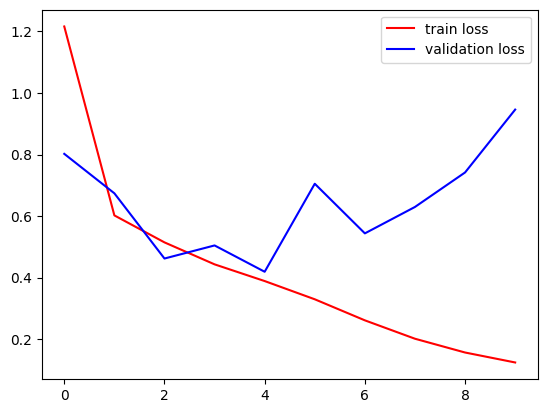

In [13]:
plt.plot(history.history['loss'],color='red',label='train loss')
plt.plot(history.history['val_loss'],color='blue',label='validation loss')
plt.legend()
plt.show()

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Create a function to extract labels and predictions from a dataset
def extract_labels_and_predictions(dataset):
    labels = []
    predictions = []
    for images, labels_batch in dataset:
        labels.extend(labels_batch.numpy())
        predictions.extend(np.round(model.predict(images)).flatten())
    return np.array(labels), np.array(predictions)

# Extract labels and predictions for the validation dataset
y_true, y_pred = extract_labels_and_predictions(validation_ds)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

1/1 [==============================] - 0s 115ms/step
Confusion Matrix:
[[2255  245]
 [ 761 1739]]


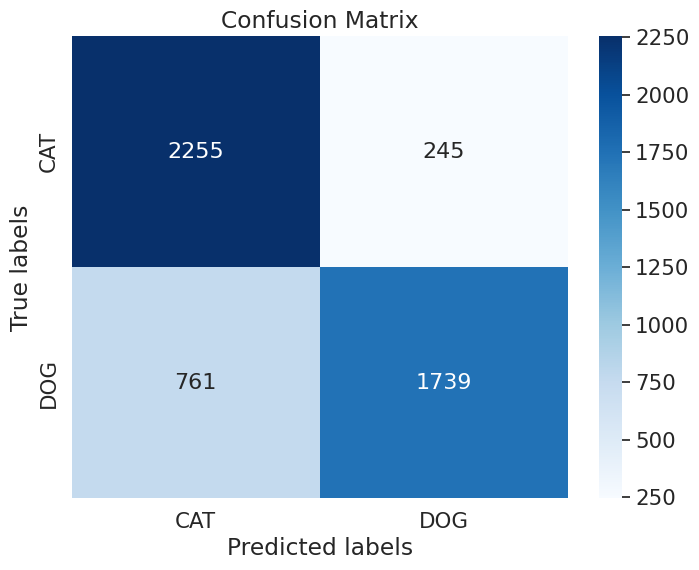

              precision    recall  f1-score   support

         CAT       0.75      0.90      0.82      2500
         DOG       0.88      0.70      0.78      2500

    accuracy                           0.80      5000
   macro avg       0.81      0.80      0.80      5000
weighted avg       0.81      0.80      0.80      5000



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns



# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g', xticklabels=["CAT", "DOG"], yticklabels=["CAT", "DOG"])  # font size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=["CAT", "DOG"]))